In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention
from tensorflow.keras.models import Model
import akshare as ak
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:

class StockPredictor:
    def __init__(self, time_window=30):
        self.time_window = time_window
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.features = ["开盘", "最高", "最低", "收盘", "成交量"]
        self.close_idx = self.features.index("收盘")

    def get_stock_data(self, stock_code, start_date="20200101", end_date="20241031"):
        """获取股票数据"""
        print(f"正在获取股票 {stock_code} 的数据...")

        try:
            df = ak.stock_zh_a_hist(
                symbol=stock_code,
                period="daily",
                start_date=start_date,
                end_date=end_date,
                adjust="qfq"
            )

            if df is not None and len(df) > 0:
                print(f"成功获取股票 {stock_code} 的数据，共 {len(df)} 行")

                # 数据预处理
                df["日期"] = pd.to_datetime(df["日期"])
                df = df.sort_values("日期")
                df.set_index("日期", inplace=True)

                # 选择特征
                available_features = [col for col in self.features if col in df.columns]
                data = df[available_features].dropna()

                return data
            else:
                print(f"股票 {stock_code} 返回空数据")
                return None

        except Exception as e:
            print(f"获取股票 {stock_code} 时出错: {e}")
            return None

    def create_simulated_data(self, stock_name="模拟股票"):
        """创建模拟数据用于测试"""
        print(f"创建 {stock_name} 的模拟数据...")
        dates = pd.date_range(start="2020-01-01", end="2024-10-31", freq='D')
        np.random.seed(42)

        # 模拟更真实的股价走势（有趋势和波动）
        n = len(dates)
        trend = np.linspace(100, 200, n)  # 上涨趋势
        noise = np.cumsum(np.random.randn(n) * 0.8)  # 随机游走
        price = trend + noise

        df = pd.DataFrame({
            '开盘': price + np.random.randn(n) * 2,
            '最高': price + np.abs(np.random.randn(n)) * 3 + 2,
            '最低': price - np.abs(np.random.randn(n)) * 3 - 2,
            '收盘': price,
            '成交量': np.random.randint(1000000, 20000000, n) + np.cumsum(np.random.randn(n) * 1000000).astype(int)
        }, index=dates)

        return df

    def prepare_data(self, data):
        """准备训练数据"""
        # 数据归一化
        scaled_data = self.scaler.fit_transform(data)

        # 划分训练集和测试集
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        # 创建序列数据
        def create_sequences(data, time_window, target_idx):
            X, y = [], []
            for i in range(time_window, len(data)):
                X.append(data[i - time_window:i])
                y.append(data[i, target_idx])
            return np.array(X), np.array(y)

        train_X, train_y = create_sequences(train_data, self.time_window, self.close_idx)
        test_X, test_y = create_sequences(test_data, self.time_window, self.close_idx)

        print(f"训练集形状: X {train_X.shape}, y {train_y.shape}")
        print(f"测试集形状: X {test_X.shape}, y {test_y.shape}")

        return train_X, train_y, test_X, test_y, train_size

    def build_model(self, input_shape):
        """构建LSTM+Attention模型"""
        inputs = Input(shape=input_shape)
        lstm_out = LSTM(64, return_sequences=True, activation='tanh', dropout=0.2)(inputs)
        attention_out = MultiHeadAttention(num_heads=4, key_dim=32)(lstm_out, lstm_out)
        combined = lstm_out + attention_out
        last_step = combined[:, -1, :]
        output = Dense(32, activation='relu')(last_step)
        output = Dense(1, activation='linear')(output)

        model = Model(inputs=inputs, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='mean_squared_error',
                     metrics=['mae'])
        return model

    def train(self, stock_codes, epochs=50, use_simulated=False):
        """训练模型（可以多个股票一起训练）"""
        all_train_X, all_train_y = [], []
        all_test_X, all_test_y = [], []

        if not isinstance(stock_codes, list):
            stock_codes = [stock_codes]

        for stock_code in stock_codes:
            if use_simulated:
                data = self.create_simulated_data(stock_code)
            else:
                data = self.get_stock_data(stock_code)
                if data is None:
                    print(f"无法获取 {stock_code} 的数据，使用模拟数据")
                    data = self.create_simulated_data(stock_code)

            train_X, train_y, test_X, test_y, _ = self.prepare_data(data)

            all_train_X.append(train_X)
            all_train_y.append(train_y)
            all_test_X.append(test_X)
            all_test_y.append(test_y)

        # 合并所有股票的数据
        train_X = np.vstack(all_train_X)
        train_y = np.hstack(all_train_y)
        test_X = np.vstack(all_test_X)
        test_y = np.hstack(all_test_y)

        print(f"合并后的训练集形状: X {train_X.shape}, y {train_y.shape}")
        print(f"合并后的测试集形状: X {test_X.shape}, y {test_y.shape}")

        # 构建和训练模型
        self.model = self.build_model((self.time_window, len(self.features)))

        print("开始训练模型...")
        history = self.model.fit(
            train_X, train_y,
            epochs=epochs,
            batch_size=32,
            validation_data=(test_X, test_y),
            verbose=1,
            shuffle=True
        )

        return history, train_X, train_y, test_X, test_y

    def predict_future(self, data, days=30):
        """预测未来价格走势"""
        if self.model is None:
            print("请先训练模型")
            return None

        # 使用最后的时间窗口数据
        last_sequence = data[-self.time_window:]
        last_sequence_scaled = self.scaler.transform(last_sequence)

        future_predictions = []
        current_sequence = last_sequence_scaled.copy()

        for _ in range(days):
            # 预测下一天
            next_pred = self.model.predict(current_sequence.reshape(1, self.time_window, len(self.features)), verbose=0)
            future_predictions.append(next_pred[0, 0])

            # 更新序列（使用预测值构建新的一天）
            new_day = current_sequence[-1].copy()
            new_day[self.close_idx] = next_pred[0, 0]

            # 移动窗口
            current_sequence = np.vstack([current_sequence[1:], new_day])

        # 反归一化预测结果
        future_predictions = self.inverse_transform_pred(
            np.array(future_predictions).reshape(-1, 1),
            self.scaler,
            self.features,
            self.close_idx
        )

        return future_predictions

    def inverse_transform_pred(self, y_pred, scaler, features, target_idx):
        """反归一化预测结果"""
        y_reshaped = np.zeros(shape=(len(y_pred), len(features)))
        y_reshaped[:, target_idx] = y_pred.flatten()
        return scaler.inverse_transform(y_reshaped)[:, target_idx]

    def evaluate_model(self, true_values, predictions, set_name="测试集"):
        """评估模型性能"""
        mae = mean_absolute_error(true_values, predictions)
        mse = mean_squared_error(true_values, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_values, predictions)

        # 计算方向准确率
        true_direction = np.diff(true_values) > 0
        pred_direction = np.diff(predictions) > 0
        direction_accuracy = np.mean(true_direction == pred_direction)

        print(f"\n{set_name} 模型评估:")
        print(f"MAE (平均绝对误差): {mae:.4f}")
        print(f"RMSE (均方根误差): {rmse:.4f}")
        print(f"R² 分数: {r2:.4f}")
        print(f"方向预测准确率: {direction_accuracy:.4f}")

        return mae, rmse, r2, direction_accuracy

    def plot_results(self, data, train_size, train_pred, test_pred, stock_name):
        """绘制结果图表"""
        train_dates = data.index[self.time_window:train_size]
        test_dates = data.index[train_size + self.time_window:]

        # 反归一化真实值
        train_y_true = self.inverse_transform_pred(
            train_pred.reshape(-1, 1), self.scaler, self.features, self.close_idx
        )
        test_y_true = self.inverse_transform_pred(
            test_pred.reshape(-1, 1), self.scaler, self.features, self.close_idx
        )

        plt.figure(figsize=(15, 10))

        # 完整的价格走势
        plt.subplot(2, 1, 1)
        plt.plot(data.index, data['收盘'], label='真实价格', color='black', alpha=0.7, linewidth=1)
        plt.plot(train_dates, train_y_true, label='训练集预测', color='blue', linewidth=1)
        plt.plot(test_dates, test_y_true, label='测试集预测', color='red', linewidth=1)
        plt.axvline(x=data.index[train_size], color='gray', linestyle='--', label='训练/测试分界线')
        plt.title(f'{stock_name} - 完整价格走势预测')
        plt.xlabel('日期')
        plt.ylabel('价格（元）')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 测试集详细视图
        plt.subplot(2, 1, 2)
        actual_test = data['收盘'].iloc[train_size + self.time_window:]
        plt.plot(test_dates, actual_test.values, label='真实价格', color='black', linewidth=2)
        plt.plot(test_dates, test_y_true, label='预测价格', color='red', linewidth=1, alpha=0.8)
        plt.title(f'{stock_name} - 测试集详细视图')
        plt.xlabel('日期')
        plt.ylabel('价格（元）')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

多股票模型训练和验证
正在获取股票 600519 的数据...
获取股票 600519 时出错: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
无法获取 600519 的数据，使用模拟数据
创建 600519 的模拟数据...
训练集形状: X (1382, 30, 5), y (1382,)
测试集形状: X (324, 30, 5), y (324,)
正在获取股票 000858 的数据...
获取股票 000858 时出错: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
无法获取 000858 的数据，使用模拟数据
创建 000858 的模拟数据...
训练集形状: X (1382, 30, 5), y (1382,)
测试集形状: X (324, 30, 5), y (324,)
正在获取股票 300750 的数据...
获取股票 300750 时出错: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
无法获取 300750 的数据，使用模拟数据
创建 300750 的模拟数据...
训练集形状: X (1382, 30, 5), y (1382,)
测试集形状: X (324, 30, 5), y (324,)
合并后的训练集形状: X (4146, 30, 5), y (4146,)
合并后的测试集形状: X (972, 30, 5), y (972,)
开始训练模型...
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0057 - mae: 0.0428 - val_loss: 0.0319 - val_mae: 0.1768
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4358e-04

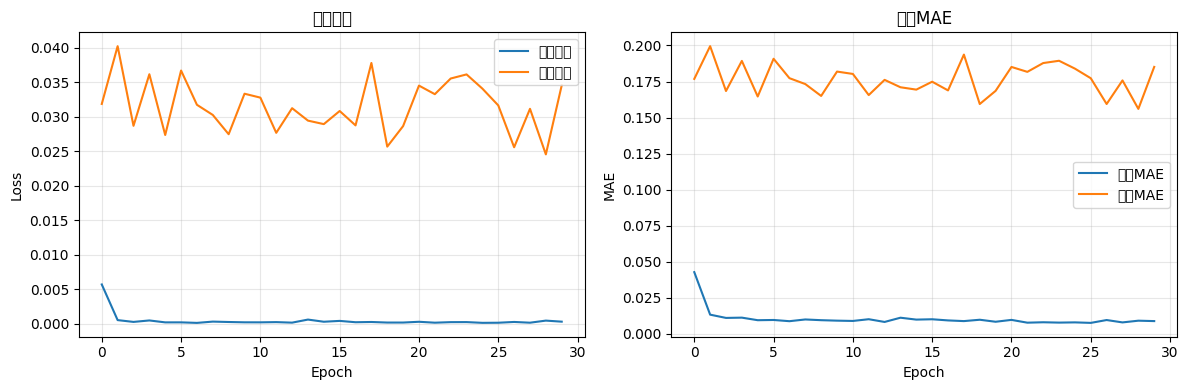

In [3]:

# ==================== 使用示例 ====================

def main():
    # 初始化预测器
    predictor = StockPredictor(time_window=30)

    # 选择要验证的股票列表
    stock_codes = ["600519", "000858", "300750"]  # 茅台, 五粮液, 宁德时代

    print("=" * 50)
    print("多股票模型训练和验证")
    print("=" * 50)

    # 1. 训练模型（使用多个股票数据）
    history, train_X, train_y, test_X, test_y = predictor.train(
        stock_codes,
        epochs=30,  # 为了演示，减少训练轮数
        use_simulated=False  # 设置为True使用模拟数据
    )

    # 2. 在测试集上进行预测
    test_pred = predictor.model.predict(test_X)

    # 3. 评估模型性能
    test_pred_inv = predictor.inverse_transform_pred(test_pred, predictor.scaler, predictor.features, predictor.close_idx)
    test_y_inv = predictor.inverse_transform_pred(test_y.reshape(-1, 1), predictor.scaler, predictor.features, predictor.close_idx)

    mae, rmse, r2, direction_acc = predictor.evaluate_model(test_y_inv, test_pred_inv, "多股票测试集")

    # 4. 对新股票进行验证
    print("\n" + "=" * 50)
    print("新股票验证")
    print("=" * 50)

    validation_stocks = ["000001", "601318"]  # 平安银行, 中国平安

    for stock_code in validation_stocks:
        print(f"\n验证股票: {stock_code}")

        # 获取验证数据
        val_data = predictor.get_stock_data(stock_code)
        if val_data is None:
            print(f"无法获取 {stock_code} 数据，跳过")
            continue

        # 准备验证数据
        val_scaled = predictor.scaler.transform(val_data)
        val_X, val_y = [], []
        for i in range(predictor.time_window, len(val_scaled)):
            val_X.append(val_scaled[i - predictor.time_window:i])
            val_y.append(val_scaled[i, predictor.close_idx])
        val_X, val_y = np.array(val_X), np.array(val_y)

        # 预测
        val_pred = predictor.model.predict(val_X)

        # 反归一化
        val_pred_inv = predictor.inverse_transform_pred(val_pred, predictor.scaler, predictor.features, predictor.close_idx)
        val_y_inv = predictor.inverse_transform_pred(val_y.reshape(-1, 1), predictor.scaler, predictor.features, predictor.close_idx)

        # 评估
        val_mae, val_rmse, val_r2, val_dir_acc = predictor.evaluate_model(val_y_inv, val_pred_inv, f"{stock_code}验证集")

        # 绘制结果
        predictor.plot_results(val_data, len(val_data), val_pred, val_pred, f"{stock_code}验证")

    # 5. 预测未来走势
    print("\n" + "=" * 50)
    print("未来走势预测")
    print("=" * 50)

    # 选择一个股票进行未来预测
    future_stock = "600519"
    future_data = predictor.get_stock_data(future_stock, start_date="20230101", end_date="20241031")

    if future_data is not None:
        # 预测未来30天
        future_predictions = predictor.predict_future(future_data, days=30)

        if future_predictions is not None:
            # 创建未来日期
            last_date = future_data.index[-1]
            future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

            # 绘制历史数据和未来预测
            plt.figure(figsize=(12, 6))

            # 历史数据（最近180天）
            recent_data = future_data.tail(180)
            plt.plot(recent_data.index, recent_data['收盘'], label='历史价格', color='blue', linewidth=2)

            # 未来预测
            plt.plot(future_dates, future_predictions, label='未来预测', color='red', linewidth=2, linestyle='--', marker='o')

            plt.axvline(x=last_date, color='gray', linestyle='--', label='预测起点')
            plt.title(f'{future_stock} - 未来30天价格预测')
            plt.xlabel('日期')
            plt.ylabel('价格（元）')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            print(f"\n{future_stock} 未来30天预测结果:")
            for i, (date, price) in enumerate(zip(future_dates, future_predictions)):
                print(f"第{i+1}天 ({date.strftime('%Y-%m-%d')}): {price:.2f}元")

    # 6. 绘制训练历史
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title('模型损失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='训练MAE')
    plt.plot(history.history['val_mae'], label='验证MAE')
    plt.title('模型MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()